## Breast Cancer detection with neural networks
This notebook contains an example of classification, using neural networks aiming to detect the severity of breast cancer on the dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from pprint import pprint
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## The dataset
This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.


In [2]:
# Importing data
data_csv = "../breast-cancer-wisconsin.csv"
df = pd.read_csv(data_csv, names=['ID','Clump','U_Cell_size','U_Cell_shape','Marginal_Adhesion','SE_epitelial_cell_size','Bare_nuclei','bland_chromatin','Normal_Nucleoli','Mitoses','Class'])
df.head()

,ID,Clump,U_Cell_size,U_Cell_shape,Marginal_Adhesion,SE_epitelial_cell_size,Bare_nuclei,bland_chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.dtypes

ID                         int64
Clump                      int64
U_Cell_size                int64
U_Cell_shape               int64
Marginal_Adhesion          int64
SE_epitelial_cell_size     int64
Bare_nuclei               object
bland_chromatin            int64
Normal_Nucleoli            int64
Mitoses                    int64
Class                      int64
dtype: object

In [4]:
# Change bare nuclei values to numeric only and check the numbers of NAN
df['Bare_nuclei'] = pd.to_numeric(df['Bare_nuclei'], errors='coerce')
print(df['Bare_nuclei'].isnull().values.sum())

# Drop the lines with null values
df = df.dropna()
print(df['Bare_nuclei'].isnull().values.sum())

16
0


#  Attribute                     Domain
-- -----------------------------------------
1. Sample code number            id number
2. Clump Thickness               1 - 10
3. Uniformity of Cell Size       1 - 10
4. Uniformity of Cell Shape      1 - 10
5. Marginal Adhesion             1 - 10
6. Single Epithelial Cell Size   1 - 10
7. Bare Nuclei                   1 - 10
8. Bland Chromatin               1 - 10
9. Normal Nucleoli               1 - 10
10. Mitoses                       1 - 10
11. Class:                        (2 for benign, 4 for malignant)

## Check the number of occurrences of both types of cancer

In [5]:
print(f"Total     = {len(df)} -> 100%")
print(f"Benign    = {len(df[df.Class == 2])} -> {len(df[df.Class == 2])/len(df) *100}%")
print(f"Malignant = {len(df[df.Class == 4])} -> {len(df[df.Class == 4])/len(df) *100}%")
from sklearn import preprocessing

Total     = 683 -> 100%
Benign    = 444 -> 65.00732064421669%
Malignant = 239 -> 34.99267935578331%


## Normalize the dataset

In [6]:
dataset = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
dataset_scaled = min_max_scaler.fit_transform(dataset)
df = pd.DataFrame(dataset_scaled)
df.head()
dataset = df.values #returns a numpy array

# Divide dataset into features and labels
x = dataset[:, 0:10].astype(float)
y = dataset[:, 10:11]

In [7]:
# Spliting data
seed = 9
# Split data set into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.15, random_state=seed
)
# Split train into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.175, random_state=seed
)

In [8]:
# Dataset dataframe
class_1 = [len(np.where(y_train[:,0]==0)[0]),len(np.where(y_val[:,0]==0)[0]),len(np.where(y_test[:,0]==0)[0])]
class_1.append(np.sum(class_1))
class_2 = [len(np.where(y_train[:,0]==1)[0]),len(np.where(y_val[:,0]==1)[0]),len(np.where(y_test[:,0]==1)[0])]
class_2.append(np.sum(class_2))
total   = [len(y_train[:,0]),len(y_val[:,0]),len(y_test[:,0])]
total.append(np.sum(total))

table_df = {'Dataset': ['Training','Validation','Test','Total'],'Porcent':[60,20,20,100], 'N benign': class_1,'N malignant': class_2,'Total':total}
table_df = pd.DataFrame(data=table_df)
table_df.to_csv('divided_dataset.csv')
table_df.head()

,Dataset,Porcent,N benign,N malignant,Total
0,Training,60,314,164,478
1,Validation,20,60,43,103
2,Test,20,70,32,102
3,Total,100,444,239,683


In [9]:
# Building the NN
lr = 0.001  # learning rate
lr_decay = 0.0005# learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "sigmoid"
optimizer = Adam(lr=lr, decay=lr_decay)
input_dim = x.shape[1]
h_n = 30
model = Sequential()
model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

# Train and validate the model
history = model.fit(
    x_train,
    y_train[:, 0],
    validation_data=(x_val, y_val[:, 0]),
    epochs=200,
    batch_size=50,
    # verbose=0,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1
        )
    ],
)

pred = model.predict(x_test)
pred = np.array(pred).flatten()
erro = pred - np.array(y_test[:, 0]).flatten()
erro = np.abs(erro)

acerto = 0
for i in erro:
    if i < 0.5:
        acerto += 1

best_pred = pred

Epoch 1/200
10/10 [==============================] - 1s 39ms/step - loss: 1.0116 - accuracy: 0.3518 - val_loss: 0.6986 - val_accuracy: 0.4175
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.3657 - val_loss: 0.5055 - val_accuracy: 0.4175
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 0.5142 - accuracy: 0.3573 - val_loss: 0.3887 - val_accuracy: 0.4078
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 0.3878 - accuracy: 0.3612 - val_loss: 0.3172 - val_accuracy: 0.3689
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 0.3295 - accuracy: 0.2634 - val_loss: 0.2675 - val_accuracy: 0.3204
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2639 - accuracy: 0.3088 - val_loss: 0.2299 - val_accuracy: 0.8252
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2237 - accuracy: 0.8333 - val_loss: 0.1981 - val_accuracy: 0.8738
Epoch 8/200


10/10 [==============================] - 0s 4ms/step - loss: 0.0356 - accuracy: 0.9625 - val_loss: 0.0326 - val_accuracy: 0.9709
Epoch 59/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0392 - accuracy: 0.9655 - val_loss: 0.0324 - val_accuracy: 0.9709
Epoch 60/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9717 - val_loss: 0.0322 - val_accuracy: 0.9709
Epoch 61/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.9635 - val_loss: 0.0321 - val_accuracy: 0.9709
Epoch 62/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 0.9556 - val_loss: 0.0320 - val_accuracy: 0.9709
Epoch 63/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0351 - accuracy: 0.9680 - val_loss: 0.0320 - val_accuracy: 0.9709
Epoch 64/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9652 - val_loss: 0.0319 - val_accuracy: 0.9709
Epoch 65/200
10/10 

Epoch 116/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0354 - accuracy: 0.9612 - val_loss: 0.0286 - val_accuracy: 0.9709
Epoch 117/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0386 - accuracy: 0.9534 - val_loss: 0.0287 - val_accuracy: 0.9709
Epoch 118/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9617 - val_loss: 0.0285 - val_accuracy: 0.9709
Epoch 119/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9631 - val_loss: 0.0285 - val_accuracy: 0.9709
Epoch 120/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0343 - accuracy: 0.9671 - val_loss: 0.0286 - val_accuracy: 0.9709
Epoch 121/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0347 - accuracy: 0.9633 - val_loss: 0.0283 - val_accuracy: 0.9709
Epoch 00121: early stopping


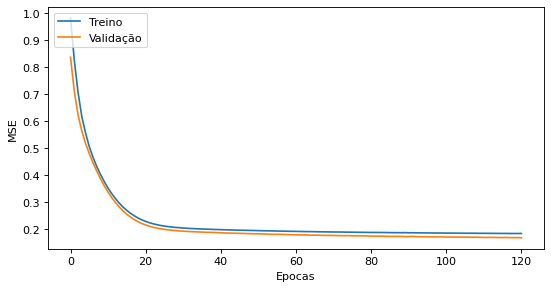

In [10]:
# Plot the validation and train loss
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.ylabel("MSE")
plt.xlabel("Epocas")
plt.legend(["Treino", "Validação"], loc="upper left")
plt.show()

In [11]:
def get_confusion_matrix(true_values, pred, labels):
    """
    Function that returns the confusion matrix for a binary classification
    
    Args:
        true_values (list): List of true values
        preditos (list): List of predicted values
        labels (list): Label value of both classes
    
    Returns:
        numpy.array, in the format:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    if len(labels) > 2:
        return None

    if len(true_values) != len(pred):
        return None
    
    # Considering the first class positive and second negative
    true_class = labels[0]
    negative_class = labels[1]

    # True positive and true negative
    tp = 0
    tn = 0
    
    # False positive and false negative
    fp = 0
    fn = 0
    
    for (i, v_real) in enumerate(true_values):
        v_pred = pred[i]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_pred == v_real else 0
            fp += 1 if v_pred != v_real else 0
        else:
            tn += 1 if v_pred == v_real else 0
            fn += 1 if v_pred != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

## Confusion Matrix

In [12]:
v_real = np.array(y_test[:,0],dtype=int).flatten()
v_pred = np.array(np.round(pred),dtype=int).flatten()
matrix = get_confusion_matrix(v_real, v_pred, [1,0])
matrix_df = {'tp': [matrix[0][0]],
             'fp': [matrix[0][1]],
             'fn': [matrix[1][0]],
             'tn': [matrix[1][1]],
            'total': [np.sum(matrix)],
            'Acc percent': [(matrix[0][0] +matrix[1][1])*100/np.sum(matrix)]}
matrix_df = pd.DataFrame(matrix_df)
matrix_df.head()

,tp,fp,fn,tn,total,Acc percent
0,31,1,2,68,102,97.058824


## Finding out the best number of neurons on the hidden layer

In [13]:
# Testing different number of neurons
neurons = [5,10,15,30]
repetitions = 2
result = list()
for neuron in neurons:
    result_i = list()
    for i in range(0,repetitions):
        lr = 0.001  # learning rate
        lr_decay = 0.0005# learning rate decay
        n_mini_batch = 100  # mini-batch length
        activation_fcn = "sigmoid"
        optimizer = Adam(lr=lr, decay=lr_decay)
        input_dim = x.shape[1]
        h_n = neuron
        model = Sequential()
        model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
        model.add(Dense(1, activation="linear"))

        # Compile model
        model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

        # Train and validate the model
        history = model.fit(
            x_train,
            y_train[:, 0],
            validation_data=(x_val, y_val[:, 0]),
            epochs=200,
            batch_size=30,
            # verbose=0,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1
                )
            ],
        )
        pred = model.predict(x_test)
        pred = np.array(pred).flatten()

        erro = pred - np.array(y_test[:, 0]).flatten()
        erro = np.abs(erro)

        acerto = 0
        for i in erro:
            if i < 0.5:
                acerto += 1

        result_i.append(acerto)
    result.append(result_i)

Epoch 1/200
16/16 [==============================] - 0s 7ms/step - loss: 3.1246 - accuracy: 0.6577 - val_loss: 3.1690 - val_accuracy: 0.5825
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 2.6674 - accuracy: 0.7013 - val_loss: 2.8797 - val_accuracy: 0.5825
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 2.4863 - accuracy: 0.6777 - val_loss: 2.6194 - val_accuracy: 0.5825
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 2.1803 - accuracy: 0.7058 - val_loss: 2.3892 - val_accuracy: 0.5825
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 2.1012 - accuracy: 0.6658 - val_loss: 2.1835 - val_accuracy: 0.5825
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 1.9122 - accuracy: 0.6646 - val_loss: 1.9997 - val_accuracy: 0.5825
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 1.7403 - accuracy: 0.6708 - val_loss: 1.8367 - val_accuracy: 0.5825
Epoch 8/200
1

Epoch 59/200
16/16 [==============================] - 0s 3ms/step - loss: 0.1794 - accuracy: 0.6440 - val_loss: 0.2029 - val_accuracy: 0.5825
Epoch 60/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.6590 - val_loss: 0.2003 - val_accuracy: 0.5825
Epoch 61/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 0.6427 - val_loss: 0.1978 - val_accuracy: 0.5825
Epoch 62/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.6746 - val_loss: 0.1955 - val_accuracy: 0.5825
Epoch 63/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1603 - accuracy: 0.6731 - val_loss: 0.1932 - val_accuracy: 0.5825
Epoch 64/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.6797 - val_loss: 0.1911 - val_accuracy: 0.5825
Epoch 65/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.6728 - val_loss: 0.1891 - val_accuracy: 0.5825
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.1120 - accuracy: 0.8596 - val_loss: 0.1254 - val_accuracy: 0.8058
Epoch 117/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.8373 - val_loss: 0.1243 - val_accuracy: 0.8058
Epoch 118/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.8570 - val_loss: 0.1232 - val_accuracy: 0.8058
Epoch 119/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1168 - accuracy: 0.8521 - val_loss: 0.1221 - val_accuracy: 0.8155
Epoch 120/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1113 - accuracy: 0.8545 - val_loss: 0.1210 - val_accuracy: 0.8350
Epoch 121/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1131 - accuracy: 0.8614 - val_loss: 0.1199 - val_accuracy: 0.8447
Epoch 122/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1042 - accuracy: 0.8881 - val_loss: 0.1188 - val_accuracy: 0.8544
Epoch 123/200

16/16 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9654 - val_loss: 0.0640 - val_accuracy: 0.9612
Epoch 174/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9702 - val_loss: 0.0631 - val_accuracy: 0.9612
Epoch 175/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9596 - val_loss: 0.0623 - val_accuracy: 0.9612
Epoch 176/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9527 - val_loss: 0.0614 - val_accuracy: 0.9612
Epoch 177/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9718 - val_loss: 0.0604 - val_accuracy: 0.9612
Epoch 178/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.9719 - val_loss: 0.0596 - val_accuracy: 0.9612
Epoch 179/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9624 - val_loss: 0.0588 - val_accuracy: 0.9612
Epoch 180/200

16/16 [==============================] - 0s 2ms/step - loss: 0.0541 - accuracy: 0.9487 - val_loss: 0.0410 - val_accuracy: 0.9709
Epoch 31/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9510 - val_loss: 0.0397 - val_accuracy: 0.9709
Epoch 32/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 0.9524 - val_loss: 0.0385 - val_accuracy: 0.9709
Epoch 33/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9615 - val_loss: 0.0375 - val_accuracy: 0.9709
Epoch 34/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9570 - val_loss: 0.0365 - val_accuracy: 0.9709
Epoch 35/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0448 - accuracy: 0.9602 - val_loss: 0.0356 - val_accuracy: 0.9709
Epoch 36/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9435 - val_loss: 0.0349 - val_accuracy: 0.9709
Epoch 37/200
16/16 

Epoch 88/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9623 - val_loss: 0.0278 - val_accuracy: 0.9806
Epoch 89/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9685 - val_loss: 0.0276 - val_accuracy: 0.9806
Epoch 90/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9726 - val_loss: 0.0276 - val_accuracy: 0.9806
Epoch 91/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9747 - val_loss: 0.0276 - val_accuracy: 0.9806
Epoch 92/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9584 - val_loss: 0.0275 - val_accuracy: 0.9806
Epoch 93/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9584 - val_loss: 0.0275 - val_accuracy: 0.9806
Epoch 94/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9769 - val_loss: 0.0274 - val_accuracy: 0.9806
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9682 - val_loss: 0.0254 - val_accuracy: 0.9806
Epoch 49/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9656 - val_loss: 0.0251 - val_accuracy: 0.9806
Epoch 50/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9635 - val_loss: 0.0250 - val_accuracy: 0.9806
Epoch 51/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9744 - val_loss: 0.0250 - val_accuracy: 0.9806
Epoch 52/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9783 - val_loss: 0.0248 - val_accuracy: 0.9806
Epoch 53/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9696 - val_loss: 0.0247 - val_accuracy: 0.9806
Epoch 54/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9778 - val_loss: 0.0247 - val_accuracy: 0.9806
Epoch 55/200
16/16 

16/16 [==============================] - 0s 2ms/step - loss: 0.0517 - accuracy: 0.9553 - val_loss: 0.0375 - val_accuracy: 0.9709
Epoch 22/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9559 - val_loss: 0.0366 - val_accuracy: 0.9709
Epoch 23/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.9481 - val_loss: 0.0358 - val_accuracy: 0.9709
Epoch 24/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 0.9538 - val_loss: 0.0351 - val_accuracy: 0.9709
Epoch 25/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9594 - val_loss: 0.0343 - val_accuracy: 0.9709
Epoch 26/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9664 - val_loss: 0.0335 - val_accuracy: 0.9709
Epoch 27/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9689 - val_loss: 0.0330 - val_accuracy: 0.9709
Epoch 28/200
16/16 

16/16 [==============================] - 0s 2ms/step - loss: 0.2795 - accuracy: 0.3293 - val_loss: 0.2055 - val_accuracy: 0.6796
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.7786 - val_loss: 0.1639 - val_accuracy: 0.9029
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9183 - val_loss: 0.1320 - val_accuracy: 0.9029
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9493 - val_loss: 0.1087 - val_accuracy: 0.9126
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1051 - accuracy: 0.9206 - val_loss: 0.0907 - val_accuracy: 0.9223
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.9529 - val_loss: 0.0779 - val_accuracy: 0.9223
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9381 - val_loss: 0.0673 - val_accuracy: 0.9320
Epoch 9/200
16/16 [======

Epoch 60/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0396 - accuracy: 0.9533 - val_loss: 0.0305 - val_accuracy: 0.9709
Epoch 61/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9590 - val_loss: 0.0304 - val_accuracy: 0.9709
Epoch 62/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9760 - val_loss: 0.0303 - val_accuracy: 0.9709
Epoch 63/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9672 - val_loss: 0.0301 - val_accuracy: 0.9709
Epoch 64/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9647 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 65/200
16/16 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 0.9538 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 66/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9587 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9651 - val_loss: 0.0261 - val_accuracy: 0.9709
Epoch 118/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 0.9678 - val_loss: 0.0261 - val_accuracy: 0.9709
Epoch 119/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9752 - val_loss: 0.0258 - val_accuracy: 0.9709
Epoch 120/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9707 - val_loss: 0.0256 - val_accuracy: 0.9709
Epoch 121/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9686 - val_loss: 0.0257 - val_accuracy: 0.9709
Epoch 122/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9700 - val_loss: 0.0259 - val_accuracy: 0.9709
Epoch 123/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9710 - val_loss: 0.0256 - val_accuracy: 0.9709
Epoch 124/200

16/16 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9692 - val_loss: 0.0306 - val_accuracy: 0.9709
Epoch 25/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9636 - val_loss: 0.0304 - val_accuracy: 0.9709
Epoch 26/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9697 - val_loss: 0.0303 - val_accuracy: 0.9709
Epoch 27/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 0.9608 - val_loss: 0.0306 - val_accuracy: 0.9709
Epoch 28/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9593 - val_loss: 0.0300 - val_accuracy: 0.9709
Epoch 29/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9744 - val_loss: 0.0301 - val_accuracy: 0.9709
Epoch 30/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9678 - val_loss: 0.0301 - val_accuracy: 0.9709
Epoch 31/200
16/16 

Epoch 82/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9745 - val_loss: 0.0263 - val_accuracy: 0.9709
Epoch 83/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9786 - val_loss: 0.0259 - val_accuracy: 0.9709
Epoch 84/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9739 - val_loss: 0.0259 - val_accuracy: 0.9709
Epoch 85/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9665 - val_loss: 0.0261 - val_accuracy: 0.9709
Epoch 86/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9711 - val_loss: 0.0258 - val_accuracy: 0.9709
Epoch 87/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9678 - val_loss: 0.0260 - val_accuracy: 0.9709
Epoch 88/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9754 - val_loss: 0.0258 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0420 - accuracy: 0.9529 - val_loss: 0.0382 - val_accuracy: 0.9612
Epoch 29/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9364 - val_loss: 0.0380 - val_accuracy: 0.9612
Epoch 30/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9551 - val_loss: 0.0376 - val_accuracy: 0.9709
Epoch 31/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9596 - val_loss: 0.0375 - val_accuracy: 0.9709
Epoch 32/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9626 - val_loss: 0.0374 - val_accuracy: 0.9709
Epoch 33/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9676 - val_loss: 0.0374 - val_accuracy: 0.9709
Epoch 34/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9572 - val_loss: 0.0372 - val_accuracy: 0.9709
Epoch 35/200
16/16 

Epoch 86/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9681 - val_loss: 0.0328 - val_accuracy: 0.9709
Epoch 87/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9611 - val_loss: 0.0326 - val_accuracy: 0.9709
Epoch 88/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9551 - val_loss: 0.0325 - val_accuracy: 0.9709
Epoch 89/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9662 - val_loss: 0.0325 - val_accuracy: 0.9709
Epoch 90/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9564 - val_loss: 0.0324 - val_accuracy: 0.9709
Epoch 91/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9742 - val_loss: 0.0322 - val_accuracy: 0.9709
Epoch 92/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9544 - val_loss: 0.0323 - val_accuracy: 0.9709
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9652 - val_loss: 0.0328 - val_accuracy: 0.9709
Epoch 45/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9599 - val_loss: 0.0327 - val_accuracy: 0.9709
Epoch 46/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9467 - val_loss: 0.0323 - val_accuracy: 0.9709
Epoch 47/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.9487 - val_loss: 0.0324 - val_accuracy: 0.9709
Epoch 48/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9593 - val_loss: 0.0325 - val_accuracy: 0.9709
Epoch 49/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9614 - val_loss: 0.0321 - val_accuracy: 0.9709
Epoch 50/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9744 - val_loss: 0.0321 - val_accuracy: 0.9709
Epoch 51/200
16/16 

Epoch 102/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9593 - val_loss: 0.0291 - val_accuracy: 0.9709
Epoch 103/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9708 - val_loss: 0.0284 - val_accuracy: 0.9709
Epoch 104/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 0.9646 - val_loss: 0.0286 - val_accuracy: 0.9709
Epoch 105/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9645 - val_loss: 0.0285 - val_accuracy: 0.9709
Epoch 106/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9690 - val_loss: 0.0287 - val_accuracy: 0.9709
Epoch 107/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.9587 - val_loss: 0.0283 - val_accuracy: 0.9709
Epoch 108/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9744 - val_loss: 0.0288 - val_accuracy: 0.9709

In [14]:
result = np.array(result).reshape((len(neurons),repetitions))

In [15]:
mean = [np.mean(i) for i in result]
acc  = np.array(result) * (100/len(y_val)) 
mean_acc = np.array(mean) * (100/len(y_val))

result_dict = {'neurons': neurons, 'results_1': result[:,0],'results_2':result[:,1], 'mean': mean, 'acc_1' : acc[:,0],'acc_2' : acc[:,1] , 'mean_acc': mean_acc}
result_df = pd.DataFrame(data=result_dict)
result_df

,neurons,results_1,results_2,mean,acc_1,acc_2,mean_acc
0,5,99,100,99.5,96.116505,97.087379,96.601942
1,10,99,99,99.0,96.116505,96.116505,96.116505
2,15,99,99,99.0,96.116505,96.116505,96.116505
3,30,99,99,99.0,96.116505,96.116505,96.116505
